In [1]:
%matplotlib notebook
#%matplotlib widget

import copy
import json
import numpy as np
import requests

from datetime import datetime
from math import ceil
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import environ, path
from pandas import DataFrame as PanDataFrame

In [2]:
out_dir = path.join(environ.get("HOME"), "Chaos", "DL")
out_file_name = "cov19"

In [3]:
euro = {"at": "Austria", "be": "Belgium", "ba": "Bosnia and Herzegovina", "bg": "Bulgaria",
        "hr": "Croatia", "cy": "Cyprus", "cz": "Czechia", "dk": "Denmark", "ee": "Estonia",
        "fi": "Finland", "fr": "France", "de": "Germany", "gr": "Greece", "hu": "Hungary",
        "ie": "Ireland", "it": "Italy", "lv": "Latvia", "li": "Liechtenstein",
        "lt": "Lithuania", "lu": "Luxembourg", "nl": "Netherlands", "no": "Norway",
        "pl": "Poland", "pt": "Portugal", "ro": "Romania", "rs": "Serbia", "sk": "Slovakia",
        "si": "Slovenia", "es": "Spain", "se": "Sweden", "ch": "Switzerland",
        "gb": "United Kingdom"}

In [4]:
regions = {"amro": ["us"],
           "euro": euro.keys()}

In [5]:
population = {"at": 8901000, "be": 11431000, "ba": 3531000, "bg": 6951000,
        "hr": 4190000, "cy": 1189000, "cz": 10637000, "dk": 5822000, "ee": 1323000,
        "fi": 5517000, "fr": 66993000, "de": 83166000, "gr": 10277000, "hu": 9773000,
        "ie": 4761000, "it": 60260000, "lv": 1934000, "li": 38000,
        "lt": 2794000, "lu": 626000, "nl": 17290000, "no": 5367000,
        "pl": 38386000, "pt": 10600000, "ro": 20121000, "rs": 7057000, "sk": 5450000,
        "si": 2064000, "es": 47100000, "se": 10327000, "ch": 8601000,
        "gb": 66435000, "us": 328000000}

In [6]:
cases_day_description = {"key": ["unix_timestamp"],
                         "values": ["cases_per_day_confirmed", "cases_cumulative",
                                    "cases_cumulative_percent_population",
                                    "deaths_per_day_confirmed", "deaths_cumulative",
                                    "deaths_cumulative_permil_population"]}
full_data = {"cases_per_day_data_description": cases_day_description,
             "countries": {}}


In [7]:
# data dimensions; (1) timestamp, (2), region, (3) deaths, (4) cumulative deaths,
# (5) deaths last 7 days, (6) Deaths Last 7 Days Change, (7) Deaths Per Million, (8) Confirmed,
# (9) Cumulative confirmed, (10) Cases Last 7 Days, (11) Cases Last 7 Days Change,
# (12) Cases Per Million
furl = "https://covid19.who.int/page-data/region/%s/country/%s/page-data.json"


In [8]:
# Fetch and convert data from all regions of interest
for reg in regions:
    for country_id in regions[reg]:
        country_name = "United States"
        region = "america"
        if country_id != "us":
            country_name = euro[country_id]
            region = "euro"

        curr_url = furl % (reg, country_id)
        res = requests.get(curr_url)
        print("Fetching country: '%s/%s' at \n\t%s" % (country_id, country_name, curr_url))
        data = json.loads(res.text)

        # Reduce to "timestamp: [confirmed, confirmed_cumulative,
        #                        case_cumulative_percent_population,
        #                        deaths, deaths_cumulative, death_cumulative_permil_population]"
        curr_country = {}
        curr_data = data["result"]["pageContext"]["countryGroup"]["data"]["rows"]
        curr_perc_pop = population[country_id]/100
        curr_perm_pop = population[country_id]/1000
        for i in curr_data:
            case_perc_pop = round(i[8]/curr_perc_pop, 3)
            death_perm_pop = round(i[3]/curr_perm_pop, 3)

            curr_country[i[0]] = [i[7], i[8], case_perc_pop, i[2], i[3], death_perm_pop]

        print("\tLatest cases: %s" % curr_country[list(curr_country.keys())[-1]])
        full_data["countries"][country_id] = {"country_name": country_name,
                                              "region": region,
                                              "population": population[country_id],
                                              "cases": curr_country}


Fetching country: 'us/United States' at 
	https://covid19.who.int/page-data/region/amro/country/us/page-data.json
	Latest cases: [299562, 21170475, 6.454, 3825, 358111, 1.092]
Fetching country: 'at/Austria' at 
	https://covid19.who.int/page-data/region/euro/country/at/page-data.json
	Latest cases: [2877, 371657, 4.175, 51, 6454, 0.725]
Fetching country: 'be/Belgium' at 
	https://covid19.who.int/page-data/region/euro/country/be/page-data.json
	Latest cases: [3, 655732, 5.736, 7, 19883, 1.739]
Fetching country: 'ba/Bosnia and Herzegovina' at 
	https://covid19.who.int/page-data/region/euro/country/ba/page-data.json
	Latest cases: [760, 114152, 3.233, 37, 4248, 1.203]
Fetching country: 'bg/Bulgaria' at 
	https://covid19.who.int/page-data/region/euro/country/bg/page-data.json
	Latest cases: [1002, 206392, 2.969, 59, 7961, 1.145]
Fetching country: 'hr/Croatia' at 
	https://covid19.who.int/page-data/region/euro/country/hr/page-data.json
	Latest cases: [562, 216848, 5.175, 43, 4266, 1.018]
Fet

In [9]:
# Save data structure to json file
fn = path.join(out_dir, ("%s.json" % out_file_name))
print("\nWriting to file %s" % fn)
with open(fn, "w") as fp:
    json.dump(full_data, fp)



Writing to file /home/sommer/Chaos/DL/cov19.json


In [10]:
# Prepare data for Europe

# calc euro population
euro_pop = sum(population.values()) - population["us"]

# congregate data; get euro sum
euro_cases = {"country_name": "EU",
              "population": euro_pop,
              "cases_total": [],
              "cases": {}}

tmp_data = copy.deepcopy(full_data)
for i in tmp_data["countries"]:
    if tmp_data["countries"][i]["region"] != "euro":
        continue

    curr_cases = tmp_data["countries"][i]["cases"]
    curr_list = curr_cases[list(curr_cases.keys())[-1]]

    # Congregate latest total euro cases
    if not euro_cases["cases_total"]:
        euro_cases["cases_total"] = curr_list
    else:
        euro_cases["cases_total"] = [sum(x) for x in zip(euro_cases["cases_total"], curr_list)]

    # Congregate daily total euro cases
    if not euro_cases["cases"]:
        euro_cases["cases"] = curr_cases
    else:
        for j in curr_cases:
            euro_cases["cases"][j] = [sum(x) for x in zip(euro_cases["cases"][j], curr_cases[j])]

# Fix euro percentages
curr_perc_pop = euro_cases["population"] / 100
curr_perm_pop = euro_cases["population"] / 1000

# Euro percentage cases total
euro_cases["cases_total"][2] = round(euro_cases["cases_total"][1] / curr_perc_pop, 3)
euro_cases["cases_total"][5] = round(euro_cases["cases_total"][4] / curr_perm_pop, 3)

# Euro percentages per day
for i in euro_cases["cases"]:
    euro_cases["cases"][i][2] = round(euro_cases["cases"][i][1] / curr_perc_pop, 3)
    euro_cases["cases"][i][5] = round(euro_cases["cases"][i][4] / curr_perm_pop, 3)


<IPython.core.display.Javascript object>


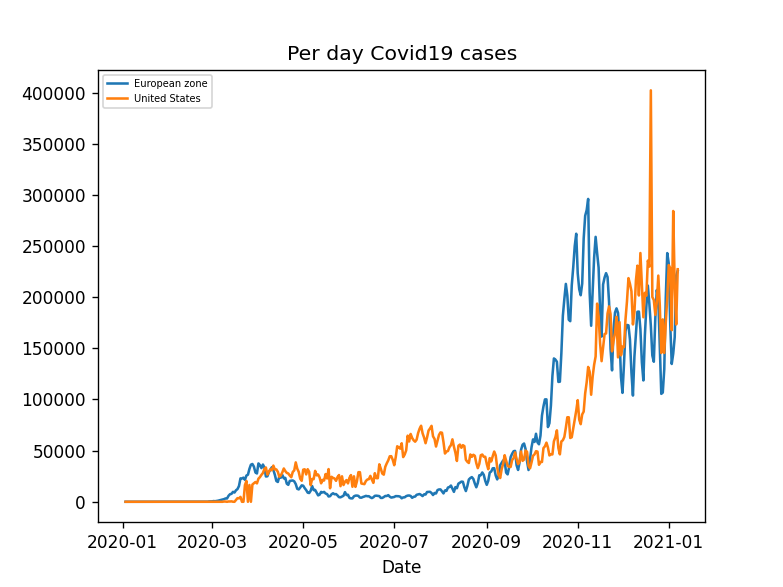

In [13]:
# Comparison Europe, US
cases_dates = []
eu_cases_confirmed = []

for i in euro_cases["cases"]:
    cases_dates.append(datetime.fromtimestamp(i/1000))
    eu_cases_confirmed.append(euro_cases["cases"][i][0])

us_cases = full_data["countries"]["us"]["cases"]
us_cases_confirmed = []

# Dirty fix to compare eu to us (us sometimes is a day ahead in terms of numbers.)
last_euro_date = cases_dates[-1]
for i in us_cases:
    us_cases_confirmed.append(us_cases[i][0])
    if last_euro_date == datetime.fromtimestamp(i/1000):
        break

# Prepare plot
ax = plt.subplot(111)
ax.set_title("Per day Covid19 cases")
ax.set_xlabel("Date")

ax.plot(cases_dates, eu_cases_confirmed, label="European zone")
ax.plot(cases_dates, us_cases_confirmed, label="United States")
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


In [14]:
def euro_country_plot(title, num_day=None):
    ax = plt.subplot(111)

    curr_len = len(cases_dates)
    marker_idx = -1
    for j in full_data["countries"]:
        if full_data["countries"][j]["region"] != "euro":
            continue

        curr_confirmed = []
        curr_data = full_data["countries"][j]["cases"]
        for i in curr_data:
            curr_confirmed.append(curr_data[i][0])

        # Handle individual markers
        marker_idx = marker_idx + 1

        country = full_data["countries"][j]["country_name"]
        if num_day:
            ax.plot(cases_dates[-num_day:-1], curr_confirmed[-num_day:-1], 
                    label=country, marker=markers_available[marker_idx])
        else:
            ax.plot(cases_dates, curr_confirmed, label=country, marker=markers_available[marker_idx])

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.legend(loc='upper left', fontsize='xx-small')
    plt.show()


<IPython.core.display.Javascript object>


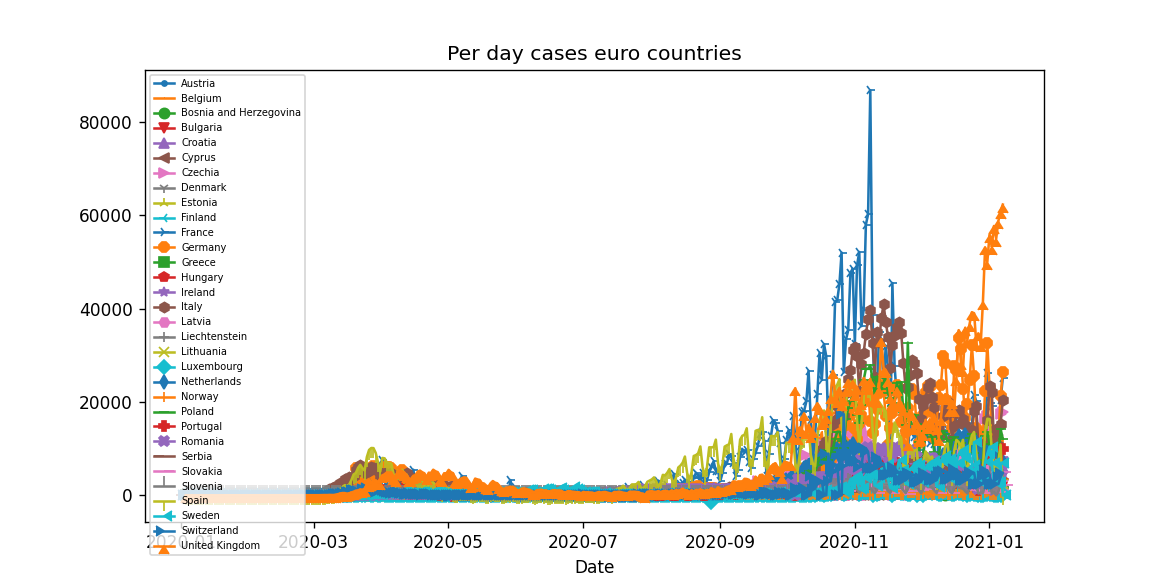

In [15]:
# Fetch list of legend markers
markers_available = list(Line2D.markers.keys())

# Europe countries per day plot
euro_country_plot("Per day cases euro countries")

<IPython.core.display.Javascript object>


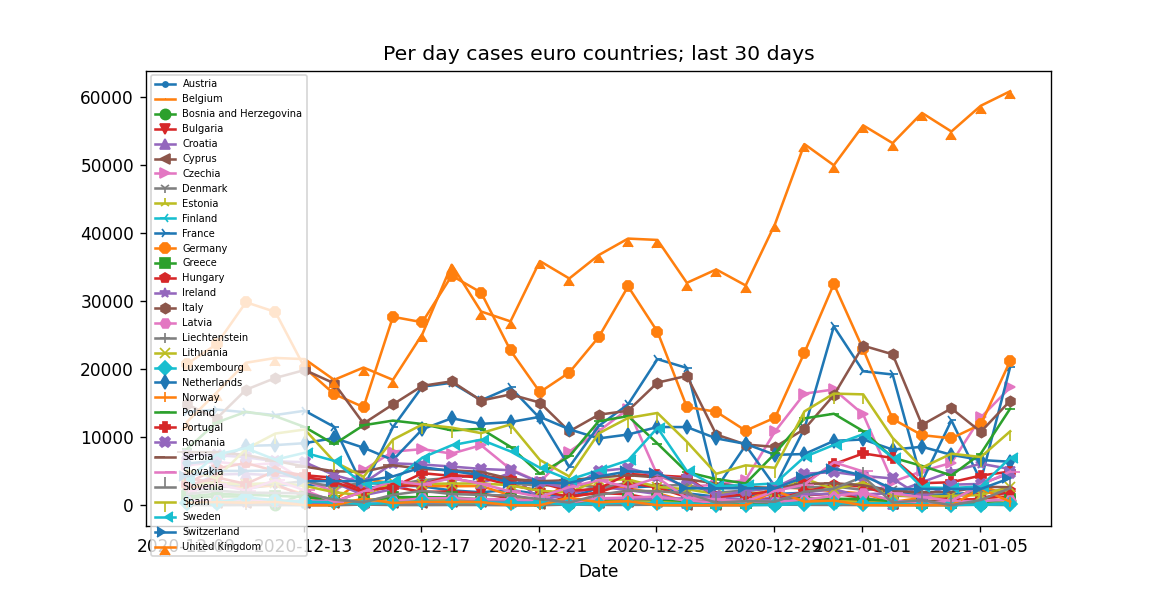

In [16]:
# Europe last days
last_days = 30
title = "Per day cases euro countries; last %s days" % last_days
euro_country_plot(title, last_days)

In [17]:
# display current numpy printoptions
print(np.get_printoptions())

# set precision to 3
np.set_printoptions(precision=3)


{'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': False}


In [18]:
def prepare_country_data(country_code):
    country_data = []
    curr_data = full_data["countries"][country_code]
    country_name = curr_data["country_name"]

    for i in curr_data["cases"]:
        country_data.append(curr_data["cases"][i][0])

    return country_data, country_name

<IPython.core.display.Javascript object>


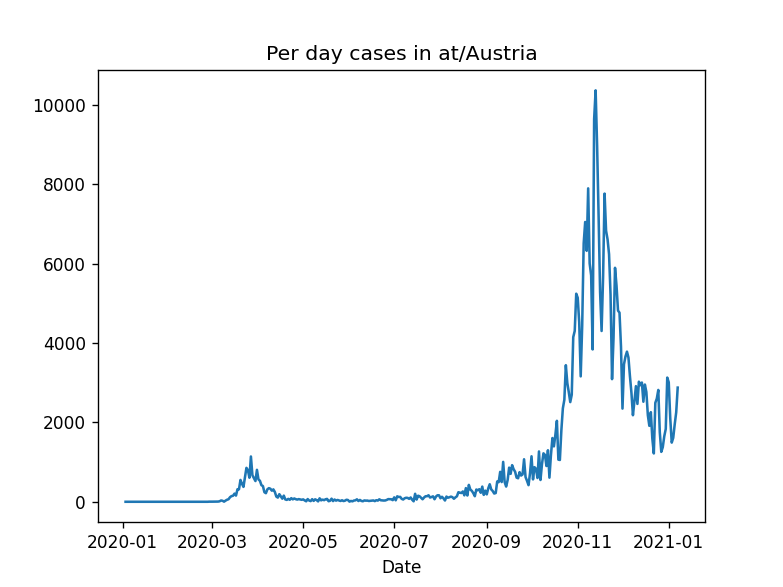

In [20]:
# Individual country plot
country_code = "at"
country_data, country_name = prepare_country_data(country_code)

ax = plt.subplot(111)
ax.plot(cases_dates, country_data)
ax.set_title("Per day cases in %s/%s" % (country_code, country_name))
ax.set_xlabel("Date")

plt.show()


<IPython.core.display.Javascript object>


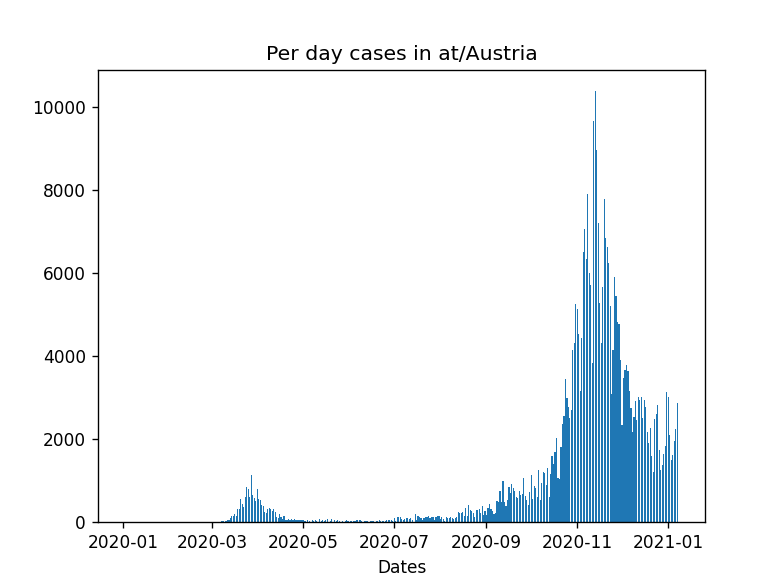

In [21]:
# Individual country bar plot
country_code = "at"
country_data, country_name = prepare_country_data(country_code)

_, ax = plt.subplots()
ax.bar(cases_dates, country_data, 0.8)
ax.set_title("Per day cases in %s/%s" % (country_code, country_name))
ax.set_xlabel("Dates")

plt.show()


In [22]:
# Format large numbers with comma as 1000 separator
def format_country_stats(cases, population):
    curr_stat = copy.deepcopy(cases)
    curr_pop = copy.deepcopy(population)
    format_pop = f'{curr_pop:,}'
    curr_case_sum = f'{curr_stat[1]:,}'
    curr_case_per = f'{curr_stat[2]:,}'
    curr_death_sum = f'{curr_stat[4]:,}'
    curr_death_per = f'{curr_stat[5]:,}'
    curr_mortality = f'{round((curr_stat[4]/(curr_stat[1]/100)),3):,}'

    return [format_pop, curr_case_sum, curr_case_per, curr_death_sum, curr_death_per, 
            curr_mortality, curr_pop, curr_stat[1], curr_stat[4]]


In [23]:
# Different stats
use_date = list(euro_cases["cases"].keys())[-1]

names = ["Europe"]
sum_only = [format_country_stats(euro_cases["cases"][use_date], euro_cases["population"])]

tmp_cases = copy.deepcopy(full_data["countries"])
for i in tmp_cases:
    sum_only.append(format_country_stats(tmp_cases[i]["cases"][use_date], tmp_cases[i]["population"]))
    names.append(tmp_cases[i]["country_name"])


In [ ]:
# morbidity ... chance to get sick dependent on the population
# mortality ... chance to die dependent on the population (in our case ignoring the time component of mortality)
# lethality ... chance to die dependent on the sick population

In [25]:
# Using pandas to print table
d_sum_only = {}

idx = 0
for curr_list in sum_only:
    d_sum_only[names[idx]] = curr_list
    idx = idx + 1

col_labels = ["population", "sum_cases", "morbidity [% pop]", "sum_deaths", 
              "mortality [‰ pop]", "lethality", "sort_pop", "sort_case", "sort_dead"]
sum_frame = PanDataFrame(d_sum_only, col_labels)

# 0 ... pop, 1 ... sum, 2 ... morbid, 3 ... sum_d, 4 ... mort, 
# 5 ... leth, 6 ... pop_sort, 7 ... case_sort, 8 ... dead_sort
hide_col = ["sort_pop", "sort_case", "sort_dead"]
sum_frame.transpose().sort_values(by=col_labels[5], ascending=False).style.hide_columns(hide_col)


,population,sum_cases,morbidity [% pop],sum_deaths,mortality [‰ pop],lethality
Bulgaria,"6,951,000","206,392",2.969,"7,961",1.145,3.857
Bosnia and Herzegovina,"3,531,000","114,152",3.233,"4,248",1.203,3.721
Greece,"10,277,000","142,267",1.384,"5,099",0.496,3.584
Italy,"60,260,000","2,201,945",3.654,"76,877",1.276,3.491
Hungary,"9,773,000","334,836",3.426,"10,325",1.056,3.084
Belgium,"11,431,000","655,732",5.736,"19,883",1.739,3.032
United Kingdom,"66,435,000","2,836,805",4.27,"77,346",1.164,2.727
Spain,"47,100,000","1,982,543",4.209,"51,430",1.092,2.594
Romania,"20,121,000","654,007",3.25,"16,299",0.81,2.492
France,"66,993,000","2,660,740",3.972,"66,184",0.988,2.487


In [ ]:
# calc sum infections last seven days
days = list(full_data["countries"]["at"]["cases"].keys())[-8:-1]

curr_data = {}
curr_plot = {}
for ccode in full_data["countries"]:
    access_data = full_data["countries"][ccode]
    curr_cases = {}

    sum_cases = 0
    for i in days:
        curr_cases[i] = access_data["cases"][i]
        sum_cases = sum_cases + access_data["cases"][i][0]

    perc_cases = round(sum_cases / (access_data["population"]/100), 3)
    curr_data[ccode] = {"country_name": access_data["country_name"],
                        "population": f'{access_data["population"]:,}',
                        "sum_cases": f'{sum_cases:,}',
                        "perc_cases": perc_cases,
                        "cases": copy.deepcopy(curr_cases)
                       }
    curr_plot[access_data["country_name"]] = [f'{access_data["population"]:,}', f'{sum_cases:,}', 
                                              perc_cases, sum_cases]


In [ ]:
# Add seven days info table
day_col_labels = ["population", "cases last 7 days", "morbidity [% pop]", "sort_cases"]

sum_frame = PanDataFrame(curr_plot, day_col_labels)

sum_frame.transpose().sort_values(by=[day_col_labels[2]], ascending=False).style.hide_columns(["sort_cases"])


In [ ]:
# Per day percent plot to properly compare increase rates per citizen
ax = plt.subplot(111)

marker_idx = -1

for j in full_data["countries"]:
    if full_data["countries"][j]["region"] != "euro":
        continue

    curr_per_day_perc = []
    population = full_data["countries"][j]["population"]
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_val = round(curr_data[i][0]/(population/1000),3)
        curr_per_day_perc.append(curr_val)

    # Handle individual markers
    marker_idx = marker_idx + 1

    country = full_data["countries"][j]["country_name"]
    ax.plot(cases_dates[-30:-1], curr_per_day_perc[-30:-1], 
            label=country, marker=markers_available[marker_idx])

ax.set_title("Per day morbidity (% pop) increase euro countries (Last 30 days)")
ax.set_xlabel("Date")
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


In [ ]:
_, axs = plt.subplots(int(ceil(len(full_data["countries"])/2)), 2, figsize=(9, 40))

cnt = 0
cntrow = 0
for ctry in full_data["countries"]:
    tmp_data = []
    for day in full_data["countries"][ctry]["cases"]:
        if ctry == "us" and last_euro_date == datetime.fromtimestamp(day/1000):
            continue
        tmp_data.append(full_data["countries"][ctry]["cases"][day][0])

    axs[cntrow, cnt].plot(cases_dates, tmp_data)
    axs[cntrow, cnt].set_title(full_data["countries"][ctry]["country_name"])
    cntrow = cntrow if cnt < 1 else cntrow + 1
    cnt = cnt + 1 if cnt < 1 else 0

plt.tight_layout(pad=4.0)


In [ ]:
# todo: comparison side by side country plots; last 30 days